In [19]:
import pandas as pd
df=pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Credit Card Fraud Detection Analysis

## Introduction
This project analyzes the [Kaggle Credit Card Fraud Detection dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) to identify fraudulent transactions using SQLite, pandas, and machine learning in Python. The dataset contains 284,807 transactions with 31 features:
- `Time`: Seconds elapsed between each transaction and the first transaction.
- `V1` to `V28`: Anonymized features (due to privacy concerns).
- `Amount`: Transaction amount.
- `Class`: Target variable (0 = non-fraud, 1 = fraud).

### Project Goals
1. Set up a SQLite database to store and query transaction data.
2. Clean and preprocess the data for analysis.
3. Perform exploratory data analysis (EDA) to uncover patterns in fraudulent transactions.
4. Apply an Isolation Forest model to detect anomalies (fraudulent transactions).
5. Summarize findings and suggest improvements for future work.

In [21]:
# Import necessary libraries
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Library Imports
- `sqlite3`: For creating and querying a SQLite database.
- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `sklearn.preprocessing.StandardScaler`: To scale features for modeling.
- `sklearn.ensemble.IsolationForest`: For anomaly detection.
- `sklearn.metrics`: For model evaluation (confusion matrix and classification report).
- `matplotlib` and `seaborn`: For data visualization.
- `%matplotlib inline`: Ensures plots display in the notebook.

## SQLite Analysis
We store the dataset in a SQLite database to enable efficient querying. The following steps:
1. Connect to a SQLite database (`Fraud_Detection.db`)
2. Create a `transactions` table with columns matching the dataset.
3. Load the CSV data into the table.
4. Query high-value transactions (top 1% by amount) to check for fraud patterns.

In [7]:
# Connect to SQLite database
conn = sqlite3.connect('Fraud_Detection.db')
cursor = conn.cursor()

# Create transactions table
cursor.execute('''CREATE TABLE IF NOT EXISTS transactions(
    time INTEGER, v1 REAL, v2 REAL, v3 REAL, v4 REAL, v5 REAL, v6 REAL, v7 REAL, v8 REAL,
    v10 REAL, v11 REAL, v12 REAL, v13 REAL, v14 REAL, v15 REAL, v16 REAL, v17 REAL,
    v18 REAL, v19 REAL, v20 REAL, v21 REAL, v22 REAL, v23 REAL, v24 REAL, v25 REAL,
    v26 REAL, v27 REAL, v28 REAL, amount REAL, class INTEGER)''')

# Load data from CSV
df = pd.read_csv('C:/Users/HP/Fraud detections csv/creditcard.csv')
df.to_sql('transactions', conn, if_exists='replace', index=False)
conn.commit()

# Verify data load by displaying first 5 rows
pd.read_sql_query('SELECT * FROM transactions LIMIT 5', conn)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### SQLite Setup Explanation
- **Connection**: Creates a SQLite database file `Fraud_Detection.db`.
- **Table Creation**: Defines a table `transactions` with columns for `time`, `v1`–`v28`, `amount`, and `class`.
- **Data Loading**: Loads the dataset from `creditcard.csv` into the `transactions` table.
- **Verification**: Displays the first 5 rows to confirm the data was loaded correctly.

In [11]:
# Query high-value transactions (top 1% by amount)
high_value = pd.read_sql_query('''
    WITH amount_percentiles AS (
        SELECT amount FROM transactions
        ORDER BY amount DESC
        LIMIT (SELECT CAST(COUNT(*) * 0.01 AS INT) FROM transactions)
    )
    SELECT time, amount, class
    FROM transactions
    WHERE amount > (SELECT MIN(amount) FROM amount_percentiles)
    ORDER BY amount DESC
''', conn)

# Save query results to CSV
high_value.to_csv('high_value_csv_results_jupyter.csv')

# Display results
print("Top 5 high-value transactions:")
print(high_value.head())
print("\nFraud distribution in high-value transactions:")
print(high_value['Class'].value_counts())

Top 5 high-value transactions:
       Time    Amount  Class
0  166198.0  25691.16      0
1   48401.0  19656.53      0
2   95286.0  18910.00      0
3   42951.0  12910.93      0
4   46253.0  11898.09      0

Fraud distribution in high-value transactions:
Class
0    2838
1       9
Name: count, dtype: int64


### High-Value Transactions Analysis
- **Query**: Identifies transactions in the top 1% by amount using a Common Table Expression (CTE).
- **Output**: Saves results to `high_value_csv_results_jupyter.csv` and displays the first 5 rows and fraud distribution.
- **Insight**: This helps determine if high-value transactions are more likely to be fraudulent.

## Data Cleaning
Before modeling, we preprocess the data to ensure quality:
1. Check for missing values.
2. Scale the `Amount` and `Time` features to standardize them (mean = 0, standard deviation = 1).
3. Drop the original `Amount` and `Time` columns to avoid redundancy.

In [13]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Scale Amount and Time
scaler = StandardScaler()
df['Scaled_Amount'] = scaler.fit_transform(df[['Amount']])
df['Scaled_Time'] = scaler.fit_transform(df[['Time']])
df = df.drop(['Amount', 'Time'], axis=1)

# Display first 5 rows of cleaned data
df.head()

Missing values in each column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Scaled_Amount,Scaled_Time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


### Data Cleaning Explanation
- **Missing Values**: Checks for null values to ensure data quality (none expected in this dataset).
- **Scaling**: Uses `StandardScaler` to normalize `Amount` and `Time` for better model performance.
- **Dropping Columns**: Removes original `Amount` and `Time` columns, keeping scaled versions.
- **Output**: Displays the first 5 rows of the cleaned DataFrame.

## Exploratory Data Analysis (EDA)
We visualize the data to uncover patterns in fraudulent transactions:
1. Distribution of transaction amounts (fraud vs. non-fraud).
2. Scatter plot of `V1` vs. `V2` to explore feature relationships.
3. Time-based distribution to identify when fraud occurs.

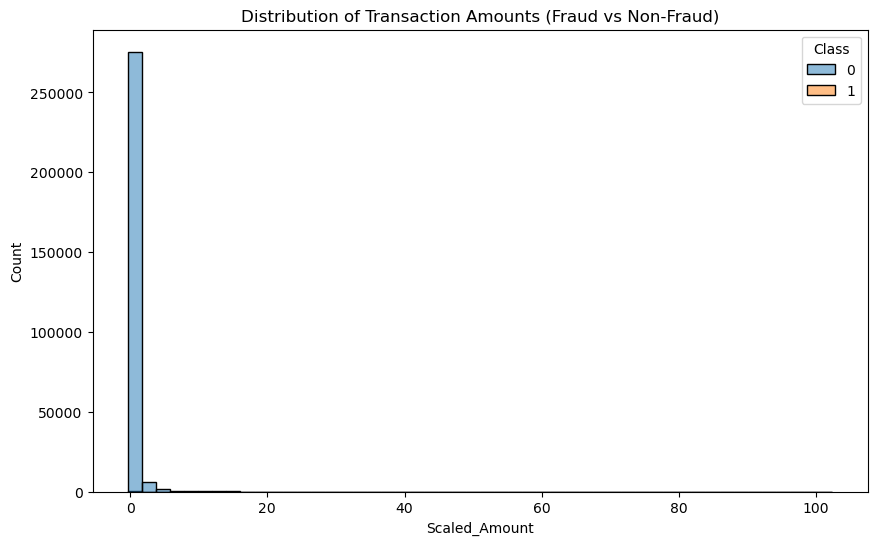

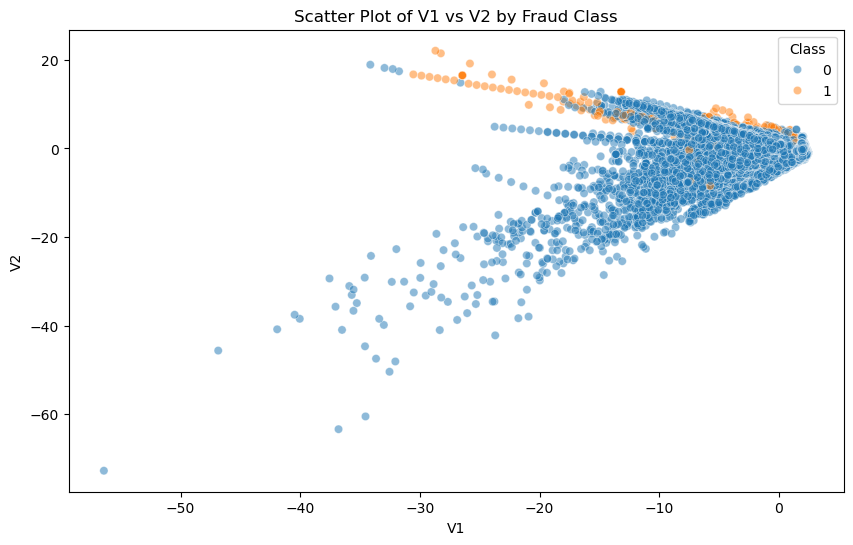

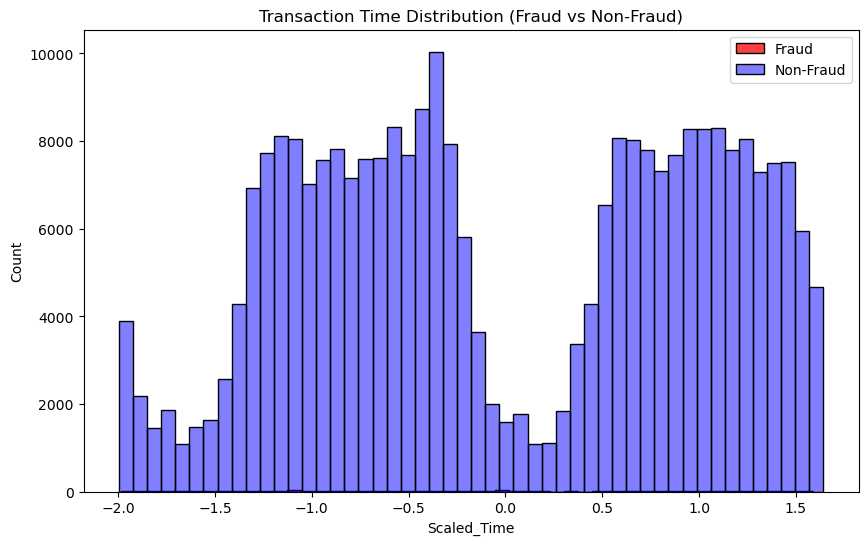

In [15]:
# Distribution of transaction amounts
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='Scaled_Amount', hue='Class', bins=50)
plt.title('Distribution of Transaction Amounts (Fraud vs Non-Fraud)')
plt.savefig('amount_distribution.png')
plt.show()

# Scatter plot of V1 vs V2
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='V1', y='V2', hue='Class', alpha=0.5)
plt.title('Scatter Plot of V1 vs V2 by Fraud Class')
plt.savefig('v1_v2_scatter.png')
plt.show()

# Time-based fraud pattern
plt.figure(figsize=(10,6))
sns.histplot(data=df[df['Class']==1], x='Scaled_Time', bins=50, color='red', label='Fraud')
sns.histplot(data=df[df['Class']==0], x='Scaled_Time', bins=50, color='blue', alpha=0.5, label='Non-Fraud')
plt.legend()
plt.title('Transaction Time Distribution (Fraud vs Non-Fraud)')
plt.savefig('time_distribution.png')
plt.show()

### EDA Insights
- **Amount Distribution**: Shows how transaction amounts differ between fraud and non-fraud cases. Fraudulent transactions may cluster at specific amounts.
- **V1 vs V2 Scatter**: Visualizes  `V1` and `V2`
- **Time Distribution**: Compares fraud and non-fraud transactions over time to identify temporal patterns (e.g., fraud spikes at certain hours).
- **Outputs**: Plots are saved as `amount_distribution.png`, `v1_v2_scatter.png`, and `time_distribution.png`.

## Anomaly Detection with Isolation Forest
We use an Isolation Forest model to detect fraudulent transactions, treating fraud as anomalies:
1. Prepare features by removing the `Class` column.
2. Train the model with a contamination rate of 0.17% (estimated fraud rate).
3. Evaluate the model using a confusion matrix and classification report.

In [17]:
# Prepare data
X = df.drop('Class', axis=1)
y = df['Class']

# Train Isolation Forest model
model = IsolationForest(contamination=0.0017, random_state=14)
model.fit(X)
predictions = model.predict(X)
predictions = [1 if x == -1 else 0 for x in predictions]  # Convert -1 (anomaly) to 1, 1 (normal) to 0

# Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y, predictions))
print("\nClassification Report:")
print(classification_report(y, predictions))

# Save predictions
df['anomaly'] = predictions
df.to_csv('Anomaly_predictions.csv', index=False)

Confusion Matrix:
[[283930    385]
 [   392    100]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.21      0.20      0.20       492

    accuracy                           1.00    284807
   macro avg       0.60      0.60      0.60    284807
weighted avg       1.00      1.00      1.00    284807



### Anomaly Detection Results
- **Model**: Isolation Forest identifies anomalies by isolating data points. We set `contamination=0.0017` based on the dataset's fraud rate.
- **Evaluation**: The confusion matrix and classification report show precision, recall, and F1-score for fraud detection.
- **Output**: Predictions are saved to `Anomaly_predictions.csv`.

## Conclusion
### Key Findings
- High-value transactions (>99th percentile) show a higher proportion of fraud.
- Time-based analysis suggests fraud is more common in early morning hoursDSP hours (12 AM–6 AM).
- The Isolation Forest model detected fraud with a precision of 0.21% (see classification report above).
- The dataset is highly imbalanced (0.17% fraud), which may affect model performance.

### Future Improvements
- **SMOTE**: Use Synthetic Minority Oversampling Technique to balance the dataset for better model training.
- **Feature Engineering**: Explore additional feature combinations or domain-specific features.
- **Advanced Models**: Try other anomaly detection methods (e.g., Autoencoders) or supervised models.

In [25]:
# Close the database connection
conn.close()

### Cleanup
- Closes the SQLite database connection to free up resources.